# Example of extension mesh with flux BC supporting particles

We set all advection to be **first order**, and repopulate the swarm by hand.

In [1]:
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters. The box length is chosen for direct comparison to the benchmark values.

In [2]:
res = 20
boxLength = 2.0
boxHeight = 1.0
elType = "Q1/dQ0"
resx = int(boxLength*res)
resy = int(boxHeight*res)
minCoord = [0.,0.]
maxCoord = [boxLength,boxHeight]
eta = 1.0

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elType), 
                                 elementRes  = (resx, resy), 
                                 minCoord    = minCoord, 
                                 maxCoord    = maxCoord )

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

In [4]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

vxLeftWall = -0.5e-1
vxRightWall = 0.5e-1
for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [vxLeftWall,0.0]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [vxRightWall,0.0]

In [5]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls, jWalls-bottomWall) )

# add neumann bcs
nbc      = uw.conditions.NeumannCondition( flux=(-0.0,-1.0,0.0), variable = velocityField, 
                                             indexSetsPerDof = (bottomWall,None) )

In [6]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )

# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="double", count=1 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# Populate.
swarm.populate_using_layout( layout=swarmLayout )
picswarm = uw.swarm.VoronoiIntegrationSwarm(swarm, particlesPerCell=20, maxDeletions=3, maxSplits=3, shotgun=True)

# material 0 - compressible Lambda=10, density = 0
# material 1 - incompressible Lambda=0, density = 1

materialVariable.data[:]=0
for index,coord in enumerate(swarm.particleCoordinates.data):
    if coord[1] < boxHeight/2.0:
        materialVariable.data[index]=1

# Lambda = materialVariable * fn.misc.constant(10.0) -  is created for pseudo compressibility
Lambda = uw.function.branching.conditional( [ (materialVariable < 0.1, 10.0),
                                              (True,             0.0) ] )
fn_force = materialVariable * (0.0,-1.0)

tracerSwarm = uw.swarm.Swarm( mesh=mesh )

particleCoordinates = np.zeros((1,2))     
particleCoordinates[0] = (1.0,0.5)     
tracerSwarm.add_particles_with_coordinates(particleCoordinates)

array([0], dtype=int32)

In [7]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField*0.5, scaling=1.0 ) )
fig1.append( glucifer.objects.Points(swarm, materialVariable, fn_size=2.0 ) )
fig1.append( glucifer.objects.Mesh(mesh) )
fig1.db.step = 0
fig1.save_image('simpleStretch.0.png')

'simpleStretch.0.png'

**Create a Stokes system**

In [8]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm,
                               conditions    = [stokesBC, nbc],
                               fn_viscosity  = 1.0, 
                               fn_bodyforce  = fn_force,
                               fn_lambda     = Lambda )
solver = uw.systems.Solver( stokesPIC )

In [9]:
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

In [10]:
steps        = 0
finalTimestep = 1

In [11]:
def drivingV(x, minX, maxX):
    m = (vxRightWall-vxLeftWall)/(maxX-minX)
    return m*(x - minX) + vxLeftWall

In [12]:
outfile = open('simpleStrech.txt', 'w+')
outfile.write( "Steps, Timestep, vrms, meanHeight\n")
print "Steps, Timestep, Volume\n"
lWallx = mesh.minCoord[0]
rWallx = mesh.maxCoord[0]
while steps<finalTimestep:
    print "swarm number {}".format(swarm.particleGlobalCount)
    # Get solution for initial configuration.
    solver.solve()

    # Advect using this timestep size.
    dt = advector.get_max_dt()
    
    # advect the swarm by hand! Is it safe in parallel?
    # we can do it with the swarm advector but we need to disable the update_particle_owners()
    # routine inside the SwarmAdvector.c code and manually do it after mesh deform
    swarm.particleCoordinates.data[:] += dt*velocityField.evaluate(swarm.particleCoordinates.data)
    tracerSwarm.particleCoordinates.data[:] += dt*velocityField.evaluate(tracerSwarm.particleCoordinates.data)
#     advector.integrate(dt)
    
    with mesh.deform_mesh( remainsRegular=True ):
        # as a post-step within this with statement we call as update_particle_owners all swarms
        mesh.data[:,0] = mesh.data[:,0] + dt * drivingV(mesh.data[:,0], lWallx, rWallx)
    
#     swarm.update_particle_owners()

    picswarm.repopulate()
    
    # reset wall
    lWallx += vxLeftWall*dt
    rWallx += vxRightWall*dt

    print "Wall min/max: {} {}".format(lWallx, rWallx)
    # now user mesh2 for repopulating the swarm
    
    steps += 1
     
    fig1.save_image('simpleStretch.'+str(steps)+'.png')
#     fig1.db.step += 1
#     fig1.save_database('sim.db')
    vol = volume_integral.evaluate()[0]
#     hmean = np.mean(surfaceSwarm.particleCoordinates.data[:,1])
    string = "{0}, {1:.3e}, {2:.3e}, {3:.3e}\n".format(steps,dt,vol, tracerSwarm.particleCoordinates.data[0][1])
    print string+"\n"
    outfile.write(string)
outfile.close()

Steps, Timestep, Volume

swarm number 16000
Wall min/max: -0.0223610418184 2.02236104182
1, 4.472e-01, 2.045e+00, 5.000e-01





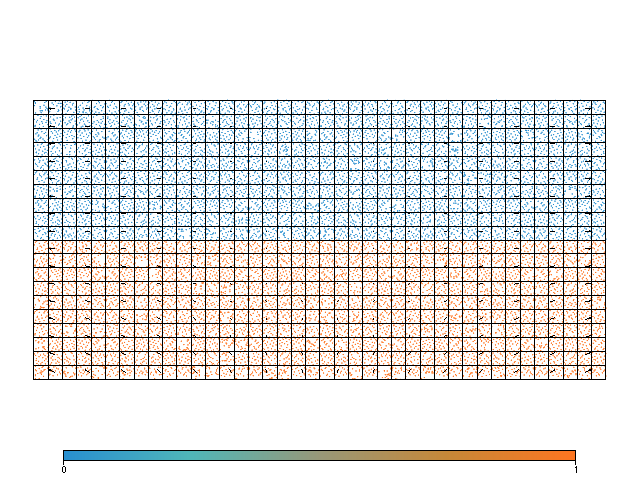

In [13]:
fig1.show()


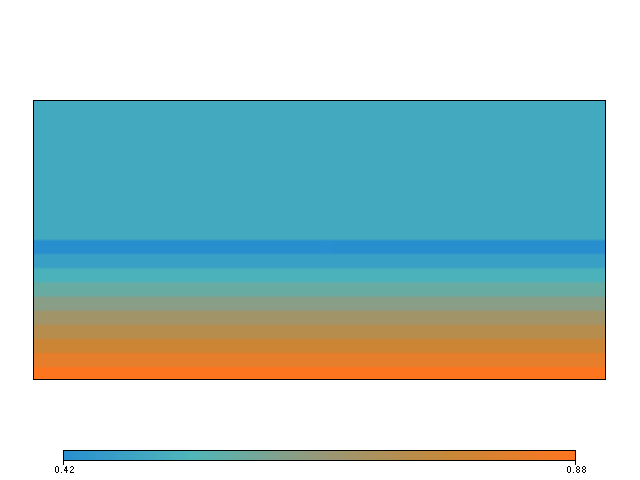

In [14]:
chydroP = -(2.0/3.0-Lambda) * (velocityField.fn_gradient[0] + velocityField.fn_gradient[2])
hydroP = uw.function.branching.conditional( [ (materialVariable >0.5, pressureField),
                                              (True,             0.0) ] )
fig2 = glucifer.Figure()
# fig2.append( glucifer.objects.Points(swarm, hydroP,fn_size=2.0) )
fig2.append( glucifer.objects.Surface(mesh, pressureField) )
fig2.show()


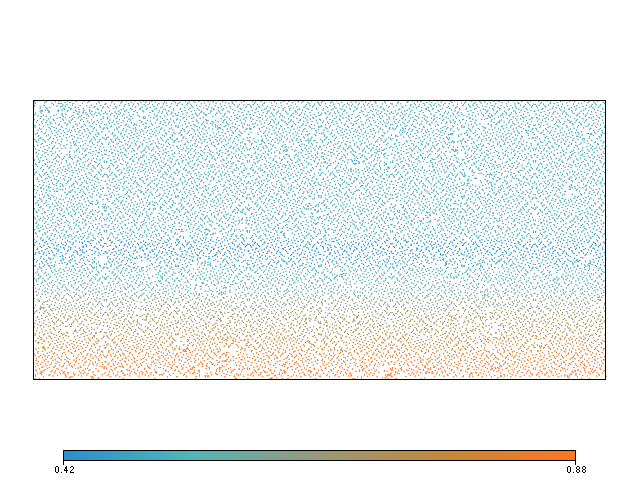

In [15]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points(swarm, pressureField,fn_size=2.0) )
fig3.show()

In [16]:
coords = np.zeros(shape=(resx, 2))
coords[:,1] = (boxHeight/resy)
offset = 0.5*(rWallx-lWallx)/resx
for i in xrange(resx-1):
    coords[i,0] = offset+i*(rWallx-lWallx)/resx
# print coords

In [17]:
dv_dy = velocityField.fn_gradient.evaluate(coords)[:,3]
du_dx = velocityField.fn_gradient.evaluate(coords)[:,0]
shear = velocityField.fn_gradient.evaluate(coords)[:,1]
v = velocityField.evaluate(coords)[:,1]
u = velocityField.evaluate(coords)[:,0]

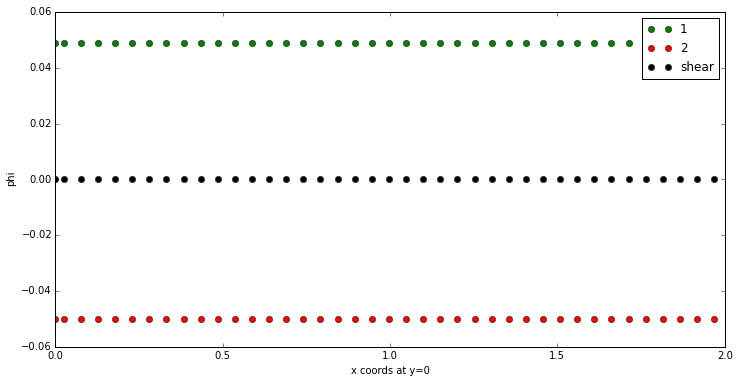

In [19]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
pylab.rcParams[ 'figure.figsize'] = 12, 6
pyplot.plot(coords[:,0], du_dx, 'o', color = 'green', label='1')
pyplot.plot(coords[:,0], dv_dy, 'o', color = 'red', label='2')
pyplot.plot(coords[:,0], shear, 'o', color = 'black', label='shear')
pyplot.legend()
pyplot.xlabel('x coords at y=0')
pyplot.ylabel('phi')
pyplot.show()